In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split

import tifffile as tiff
import os
import time

Initial arch didn't worked. changed from autoencodeer classs to autoencodering. change was just in padding = 1 to padding = 0 in encoder part. because I want to add padding as much as possible so that edge details won't loose (Andrew ng lecture)
I tried with 96*96 image. now I'm trying with 256*256 now to see how it works with high resolution will see the change in orig images and reconstructed images for high resolution to see if it works better. my gut feeling says it will be same effect that we got from 96*96 and it takes more epochs to get the same lose value 0.0005 we got it in epoch 88 in 96*96 case.

loss is not decreasing when it comes to 256*256. ask chatgpt by giving the comaprison with 96, then it may say what to do if we increase the size what changes should make to the architecture like add more dense or something like that. learning rate change to 0.00001?

In [136]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        return image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256),
    ])

# Create the dataset
image_dir = r"../../Day10_drugscreened&singledose_untreated"


dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [137]:
for i, image in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  image: {image.shape}")
    break

Batch 0:
  image: torch.Size([16, 3, 256, 256])


In [138]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),  # Removed padding here to get 96 *96 at output

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),  # Removed padding here to get 96 *96 at output

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)  # Removed padding here to get 96 *96 at output
        )
        
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output: (3, 96, 96)
            
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [144]:
class Autoencodering(nn.Module):
    def __init__(self):
        super(Autoencodering, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Input: (3, 96, 96) Output: (64, 96, 96)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (64, 48, 48)
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1), # Output: (32, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1),        # Output: (32, 24, 24)
            
            nn.Conv2d(32, 16, kernel_size=3, padding=1), # Output: (16, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)         # Output: (16, 12, 12)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1), # Output: (16, 12, 12)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (16, 24, 24)
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: (32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (32, 48, 48)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (64, 48, 48)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'), # Output: (64, 96, 96)
            
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output: (3, 96, 96)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #print("Input:", x.shape)
        
        # Encoder
        for layer in self.encoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        # Decoder
        for layer in self.decoder:
            x = layer(x)
            #print(f"After {layer}: {x.shape}")
        
        return x


In [145]:
auto = Autoencoder()
auto

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Upsample(scale_factor=2

In [146]:
# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [147]:
modeling = Autoencodering()

In [148]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    modeling.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = modeling(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    modeling.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = modeling(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/100], Train Loss: 0.0417, Validation Loss: 0.0366, Time: 14.10 seconds
Epoch [2/100], Train Loss: 0.0390, Validation Loss: 0.0372, Time: 14.23 seconds
Epoch [3/100], Train Loss: 0.0412, Validation Loss: 0.0376, Time: 17.60 seconds
Epoch [4/100], Train Loss: 0.0409, Validation Loss: 0.0376, Time: 13.43 seconds
Epoch [5/100], Train Loss: 0.0403, Validation Loss: 0.0407, Time: 13.95 seconds
Epoch [6/100], Train Loss: 0.0390, Validation Loss: 0.0375, Time: 13.98 seconds
Epoch [7/100], Train Loss: 0.0408, Validation Loss: 0.0403, Time: 14.00 seconds
Epoch [8/100], Train Loss: 0.0406, Validation Loss: 0.0385, Time: 14.05 seconds
Epoch [9/100], Train Loss: 0.0403, Validation Loss: 0.0371, Time: 13.91 seconds
Epoch [10/100], Train Loss: 0.0407, Validation Loss: 0.0392, Time: 14.04 seconds
Epoch [11/100], Train Loss: 0.0400, Validation Loss: 0.0364, Time: 14.07 seconds
Epoch [12/100], Train Loss: 0.0400, Validation Loss: 0.0379, Time: 13.97 seconds
Epoch [13/100], Train Loss: 0.0396, V

In [31]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch
    
    model.train()
    train_loss = 0
    for images in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Calculate epoch duration
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')


Epoch [1/100], Train Loss: 0.0021, Validation Loss: 0.0024, Time: 9.77 seconds
Epoch [2/100], Train Loss: 0.0023, Validation Loss: 0.0020, Time: 9.86 seconds
Epoch [3/100], Train Loss: 0.0019, Validation Loss: 0.0015, Time: 10.60 seconds
Epoch [4/100], Train Loss: 0.0017, Validation Loss: 0.0013, Time: 17.64 seconds
Epoch [5/100], Train Loss: 0.0016, Validation Loss: 0.0014, Time: 17.35 seconds
Epoch [6/100], Train Loss: 0.0016, Validation Loss: 0.0016, Time: 11.54 seconds
Epoch [7/100], Train Loss: 0.0015, Validation Loss: 0.0013, Time: 14.38 seconds
Epoch [8/100], Train Loss: 0.0014, Validation Loss: 0.0013, Time: 17.61 seconds
Epoch [9/100], Train Loss: 0.0014, Validation Loss: 0.0014, Time: 17.50 seconds
Epoch [10/100], Train Loss: 0.0014, Validation Loss: 0.0010, Time: 17.55 seconds
Epoch [11/100], Train Loss: 0.0012, Validation Loss: 0.0012, Time: 17.33 seconds
Epoch [12/100], Train Loss: 0.0012, Validation Loss: 0.0011, Time: 11.44 seconds
Epoch [13/100], Train Loss: 0.0012, Val

In [35]:
# Save the model parameters after training
torch.save(model.state_dict(), 'model.pth')


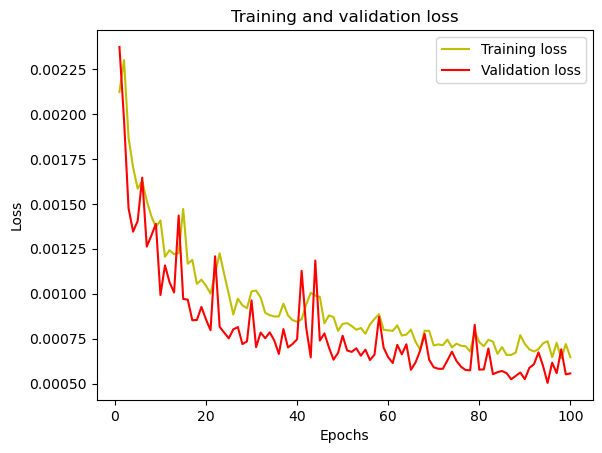

In [33]:
# Plot training and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'y', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


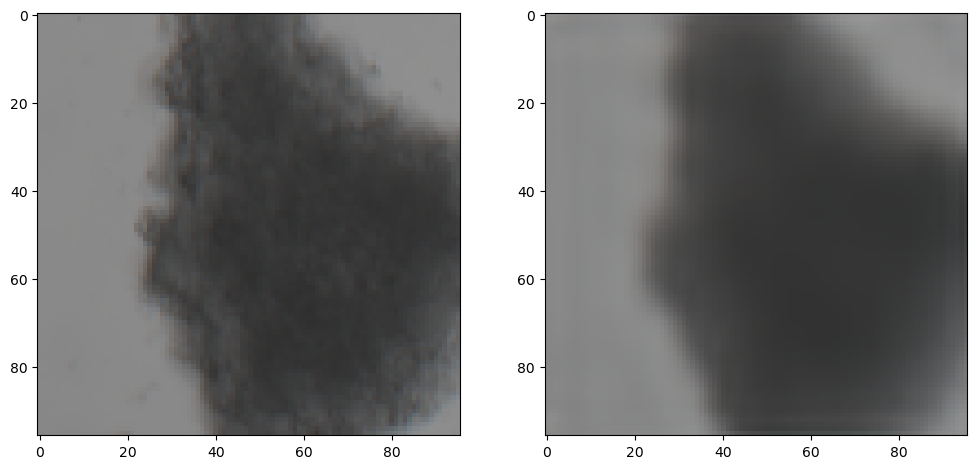

In [34]:
# Testing on a batch of images
data_batch = next(iter(train_loader))
images = data_batch
model.eval()
with torch.no_grad():
    outputs = model(images)

# Display original and reconstructed images
image_number = random.randint(0, outputs.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.transpose(images[image_number].numpy(), (1, 2, 0)))
plt.subplot(122)
plt.imshow(np.transpose(outputs[image_number].numpy(), (1, 2, 0)))
plt.show()

In [ ]:
# Evaluate reconstruction error for validation and anomaly datasets
def evaluate_reconstruction_error(data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in data_loader:
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(data_loader)

validation_error = evaluate_reconstruction_error(validation_loader)
anomaly_error = evaluate_reconstruction_error(anomaly_loader)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

In [ ]:

#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)








#We use these mean and sigma to set thresholds. 
def calc_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        
        recon_error_list.append(reconstruction_error)
        
   
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return  average_recon_error, stdev_recon_error

#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_recon_error(train_batch)
anomaly_values = calc_recon_error(anomaly_batch)


#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
     #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")
        
        
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('cell_images2/parasitized/images/*')
uninfected_file_paths = glob.glob('cell_images2/uninfected_train/images/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])